# Examples of using the draft package 'propensity_reweighting'

In [1]:
from propensity_reweighting.src.reweight import PropensityReweighter
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import logging
import yaml

logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
np.random.seed(48)

In [2]:
with open('./propensity_reweighting/config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

texts = pd.read_csv('./llm_propensity/qa_data_gpt_llama.csv')

## Base 'fit' method

In [3]:
original = texts[texts["Time"] == 'original']["Question"].tolist()
target = texts[texts["Time"] == 'future']["Question"].tolist()

In [4]:
from propensity_reweighting.src.reweight import PropensityReweighter

pr = PropensityReweighter(config)
_ = pr.fit(original, target)

Mean k2 on non-weighted test data: 0.2353
Mean EMD on non-weighted test data: 0.0662
Mean ED on non-weighted test data: 0.1332

Mean k2 on weighted test data: 0.1955
Mean EMD on weighted test data: 0.0537
Mean ED on weighted test data: 0.1077



In [5]:
weights = pr.predict(target)
weights[:10]

array([1.82027115, 1.57874549, 1.82027115, 1.89444131, 1.45053357,
       1.4528157 , 1.66747493, 1.57904128, 1.6913386 , 1.62518438])

Text(0.5, 1.0, 'predicted weights')

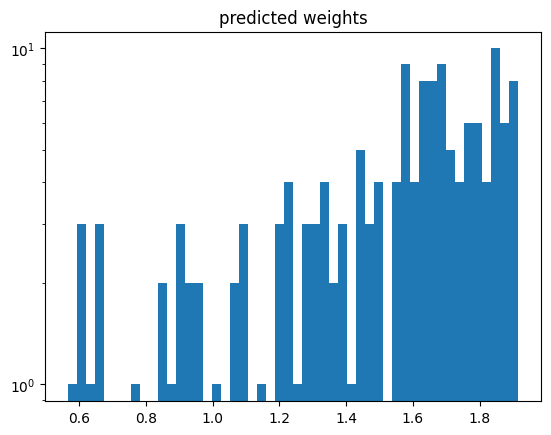

In [6]:
plt.hist(weights, bins=50)
plt.yscale('log')
plt.title('predicted weights')

## 'fit' with custom GridSearchCV 

In [3]:
original = texts[texts["Time"] == 'original']["Question"].tolist()
target = texts[texts["Time"] == 'future']["Question"].tolist()

In [4]:
from propensity_reweighting.src.reweight import PropensityReweighter

grid_values = {'n_estimators': [30, 100], 
               'learning_rate':[0.01, 0.001, 0.009],
               'max_depth': [5, 10],
               'min_samples_leaf': [1, 10, 100]}

pr = PropensityReweighter(config)
best_predictor = pr.fit_gridsearch(original, target, grid_values)

  0%|          | 0/36 [00:00<?, ?it/s]

Results:
({'n_estimators': 100, 'learning_rate': 0.009, 'max_depth': 5, 'min_samples_leaf': 1}, 0.027573379091440448)
({'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 10, 'min_samples_leaf': 10}, 0.026775148148576972)
({'n_estimators': 100, 'learning_rate': 0.009, 'max_depth': 5, 'min_samples_leaf': 10}, 0.026429746813873334)
({'n_estimators': 100, 'learning_rate': 0.009, 'max_depth': 10, 'min_samples_leaf': 10}, 0.026383393071299232)
({'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 10, 'min_samples_leaf': 1}, 0.025435030131440977)
Best Parameters: {'n_estimators': 100, 'learning_rate': 0.009, 'max_depth': 5, 'min_samples_leaf': 1}
Error: 0.027573379091440448

Mean k2 on non-weighted test data: 0.2353
Mean EMD on non-weighted test data: 0.0662
Mean ED on non-weighted test data: 0.1332

Mean k2 on weighted test data: 0.1591
Mean EMD on weighted test data: 0.0386
Mean ED on weighted test data: 0.0765



In [5]:
best_weights = best_predictor.predict(target)
best_weights[:10]

array([1.30878491, 5.73613099, 2.28492   , 6.115655  , 5.32396158,
       1.85894275, 1.92759861, 2.58848909, 6.07864215, 1.93103268])

Text(0.5, 1.0, 'predicted weights')

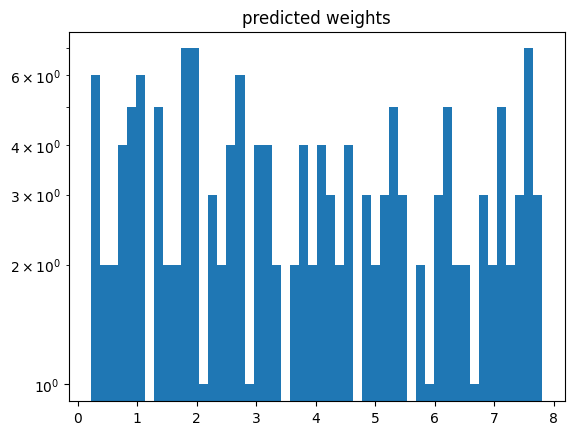

In [6]:
plt.hist(best_weights, bins=50)
plt.yscale('log')
plt.title('predicted weights')

## future's and past's analysis from QA data

In [ ]:
original = texts[texts["unit"] == 'original']["Question"].tolist()

results = {}
for i in tqdm(range(1, 8)):
    cur_shift = f'past-{i}'
    target = texts[texts["unit"] == cur_shift]["Question"].tolist()
    target_train, target_test  = target[:len(target) // 3], target[len(target) // 3:]
    labels = [texts[texts["unit"] == cur_shift]["gpt3_is_correct"].tolist()[len(target) // 3:],
             texts[texts["unit"] == cur_shift]["gpt4_is_correct"].tolist()[len(target) // 3:],
             texts[texts["unit"] == cur_shift]["llama2_is_correct"].tolist()[len(target) // 3:],
             texts[texts["unit"] == cur_shift]["llama3_is_correct"].tolist()[len(target) // 3:]]
    
    grid_values = {'n_estimators': [30, 100], 
               'learning_rate':[0.01, 0.001, 0.009],
               'max_depth': [5, 10],
               'min_samples_leaf': [1, 10, 100]}

    pr = PropensityReweighter(config)
    best_predictor = pr.fit_gridsearch(original, target_train, grid_values)
    
    best_weights = best_predictor.predict(target_test)
    
    accuracy_all = []
    f1_all = []
    f1_all.append(f"{len(target_train)} / {len(target_test)}")
    for model_pred in labels:
        # ac = round(accuracy_score([1] * len(model_pred), model_pred), 3), round(accuracy_score([1] * len(model_pred), model_pred, sample_weight=best_weights), 3)
        f1 = round(f1_score([1] * len(model_pred), model_pred), 3), round(f1_score([1] * len(model_pred), model_pred, sample_weight=best_weights), 3)
        
        # accuracy_all.append(f"{ac[0]} - {ac[1]}")
        f1_all.append(f"{f1[0]} / {f1[1]}")
        
    # results[cur_shift] = {'accuracy': accuracy_all, 'f1-score': f1_all}
    results[cur_shift] = {'f1-score': f1_all}

In [9]:
df = pd.DataFrame([], columns=["shift", "num_samples", "f1_gpt3", "f1_gpt4", "f1_llama2", "f1_llama3"])

for item in results:
    df = pd.concat(
        [df, pd.DataFrame([[item, results[item]["f1-score"][0],
                            results[item]["f1-score"][1], 
                            results[item]["f1-score"][2], 
                            results[item]["f1-score"][3],
                            results[item]["f1-score"][4]]], columns=["shift", "num_samples", "f1_gpt3", "f1_gpt4", "f1_llama2", "f1_llama3"])],
        ignore_index=True,)

In [5]:
# target_test
df

,shift,num_samples,f1_gpt3,f1_gpt4,f1_llama2,f1_llama3
0,future+1,10 / 22,0.872 / 0.868,0.778 / 0.815,0.429 / 0.509,0.625 / 0.406
1,future+2,7 / 15,0.846 / 0.836,0.929 / 0.913,0.571 / 0.609,0.696 / 0.681
2,future+3,5 / 12,0.857 / 0.733,0.8 / 0.715,0.4 / 0.349,0.588 / 0.568
3,future+4,4 / 8,0.857 / 0.58,0.769 / 0.895,0.222 / 0.176,0.769 / 0.893
4,future+5,3 / 8,0.857 / 0.862,0.667 / 0.674,0.545 / 0.486,0.667 / 0.674
5,future+6,3 / 6,0.8 / 0.799,0.667 / 0.633,0.5 / 0.482,0.5 / 0.482
6,future+7,2 / 6,0.8 / 0.855,0.909 / 0.927,0.667 / 0.758,0.8 / 0.855


In [10]:
# past_test
df

,shift,num_samples,f1_gpt3,f1_gpt4,f1_llama2,f1_llama3
0,past-1,6 / 14,0.923 / 0.942,0.923 / 0.837,0.526 / 0.491,0.783 / 0.746
1,past-2,4 / 9,0.8 / 0.684,0.875 / 0.761,0.615 / 0.512,0.364 / 0.291
2,past-3,3 / 6,0.8 / 0.825,0.8 / 0.825,0.0 / 0.0,0.667 / 0.688
3,past-4,3 / 6,0.8 / 0.81,0.8 / 0.81,0.286 / 0.235,0.8 / 0.81
4,past-5,1 / 4,0.667 / 0.443,0.857 / 0.787,0.0 / 0.0,0.4 / 0.249
5,past-6,1 / 2,0.667 / 0.447,0.667 / 0.447,0.0 / 0.0,0.667 / 0.447
6,past-7,1 / 2,0.667 / 0.845,0.667 / 0.845,0.0 / 0.0,0.667 / 0.845
